In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import cufflinks as cf
cf.go_offline()

In [3]:
url_ty="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
#url_1="https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
death_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
df = pd.read_csv(url_ty, error_bad_lines = False)
deathf = pd.read_csv(death_url, error_bad_lines = False)

In [4]:
date_cols = [x for x in df.columns if x[-1]=="0"]

In [5]:
death_date_cols = [x for x in deathf.columns if x[-1]=="0"]

In [6]:
#confirmed time series

counties = df.copy()  
confirmed = df.groupby("Province_State")[date_cols].sum()
confirmed_reset = df.groupby("Province_State")[date_cols].sum().reset_index()

In [7]:
#death time series

death = deathf.groupby("Province_State")[death_date_cols].sum() 
death_reset = deathf.groupby("Province_State")[death_date_cols].sum().reset_index()

In [8]:
big_state_death = death[(death["8/7/20"]>5000)]

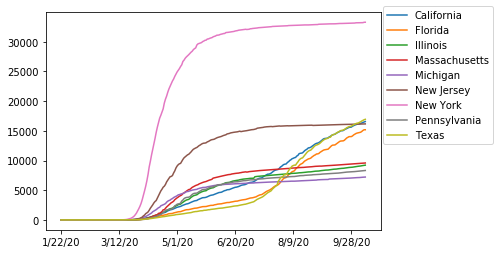

In [9]:
#cumulative deaths for worst hit states

big_state_death.T.plot().legend(loc='upper right', bbox_to_anchor=(1.35, 1.05))

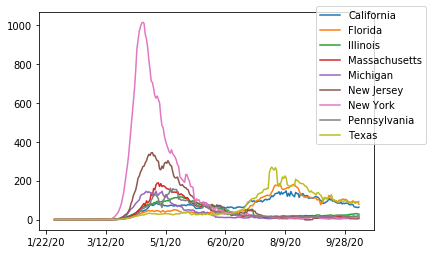

In [10]:
#daily incident deaths in worst hit states

big_state_death.T.diff().rolling(7).mean().plot().legend(loc='upper right', bbox_to_anchor=(1.17, 1.05))

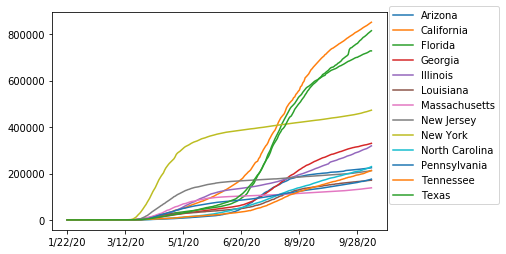

In [11]:
# confirmed cases of largest states

big_states = confirmed[(confirmed["8/7/20"]>100000) & (confirmed["8/7/20"]<1000000)]
big_states.T.plot().legend(loc='upper right', bbox_to_anchor=(1.35, 1.05))

In [12]:
#daily incident cases of Largest states

big_states.T.diff().rolling(7).mean().iplot()

In [13]:
#grab state populations from death data and merge into confirmed cases

county_pop = deathf["Population"]
state_pop = deathf.groupby("Province_State")["Population"].sum().T
confirmed_w_pop = pd.merge(confirmed, pd.DataFrame(state_pop), left_index=True, right_index=True)
counties_w_pop = pd.merge(counties, pd.DataFrame(county_pop), left_index = True, right_index = True)

In [14]:
#divide each day in time series by the states population

confirmed_norm = confirmed_w_pop.iloc[:,:-1].div(confirmed_w_pop["Population"], axis=0)
counties_norm = counties_w_pop.iloc[:,11:-1].div(counties_w_pop["Population"], axis=0)
temp = pd.merge(pd.DataFrame(counties_w_pop["Admin2"]), pd.DataFrame(counties_w_pop["Province_State"]), left_index = True, right_index = True)
counties_norm = pd.merge(temp, counties_norm, left_index = True, right_index = True).dropna()

In [15]:
#find states hit worst as a proportion of population( yvalues are in percents)

conf_norm_range = confirmed_norm[(confirmed_norm["8/7/20"]>.017) & (confirmed_norm["8/7/20"]<1)]
conf_norm_range.T.iplot()        #.legend(loc='upper right', bbox_to_anchor=(1.45, 1.05))

In [16]:
# daily incident cases as a percent of population

conf_norm_range.T.diff().rolling(14).mean().iplot()    #.legend(loc='upper right', bbox_to_anchor=(1.45, 1.05))

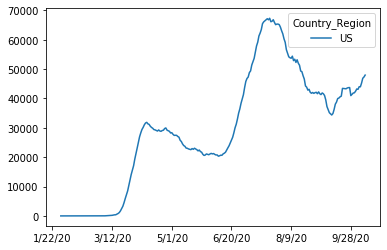

In [17]:
# U.S. daily incident case numbers

df.groupby("Country_Region")[date_cols].sum().T.diff().rolling(7).mean().plot()

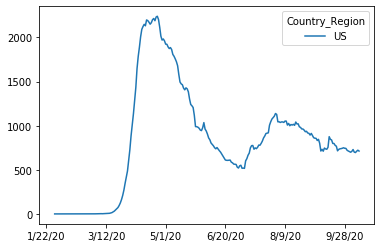

In [18]:
# U.S. daily covid deaths

deathf.groupby("Country_Region")[date_cols].sum().T.diff().rolling(7).mean().plot()

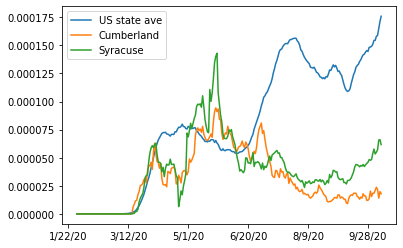

In [132]:
#Average US state daily confirmed cases vs Onondaga, NY vs Cumberland, Maine as a percent of population

confirmed_norm = confirmed_norm[np.isfinite(confirmed_norm).all(1)]
us = pd.DataFrame(confirmed_norm.mean().T.diff().rolling(7).mean()).rename(columns={0: 'US state ave'})
ny = pd.DataFrame(counties_norm[counties_norm["Admin2"] == "Onondaga"][date_cols].T.diff().rolling(7).mean()).rename(columns={1933: 'Syracuse'})
maine = counties_norm[(counties_norm["Province_State"] == "Maine") & (counties_norm["Admin2"] == "Cumberland")][date_cols].T.diff().rolling(7).mean().rename(columns={1221: 'Cumberland'})
pd.merge(pd.merge(us,maine,left_index=True, right_index=True),ny,left_index=True, right_index=True).plot()

8 week cumulative cases

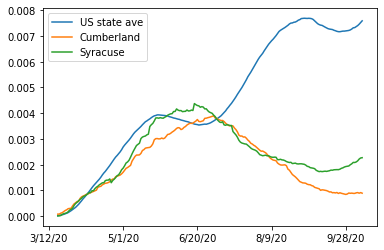

In [152]:
#Average US state vs Onondaga, NY vs Cumberland, Maine 
#comparison metric is 8 week cumulative incident cases as a percent of population
#this metric represents a liberal approximation of active cases

us =pd.DataFrame(confirmed_norm.mean().T.diff().rolling(7*8).sum().rename('US state ave'))
ny = pd.DataFrame(counties_norm[counties_norm["Admin2"] == "Onondaga"][date_cols].T.diff().rolling(7*8).sum().rename(columns={1933: 'Syracuse'}))
maine = counties_norm[(counties_norm["Province_State"] == "Maine") & (counties_norm["Admin2"] == "Cumberland")][date_cols].T.diff().rolling(7*8).sum().rename(columns={1221: 'Cumberland'})
pd.merge(pd.merge(us,maine,left_index=True, right_index=True),ny,left_index=True, right_index=True).plot()